In [1]:
import sys
sys.path.append('../')

import json
from instruments.swap import *
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Market curves

In [2]:
class Market:
    def __init__(self) -> None:
        self.market_dfs = pd.read_csv('../data/markets/Market_2023_09_29_DFs.csv', 
                                        skiprows= 2,
                                        on_bad_lines='skip')
        self.evaluation_date = date(2023,9,29)
        Settings.evaluation_date = self.evaluation_date
        self._eur_6m_index_init()
    
    @property
    def estr_curve(self):
        df_eur = self.market_dfs[self.market_dfs['Property'].str.contains("IR.EUR-ESTR-ON.DF")][['Property', 'Label']]
        dates = []
        for i in range(len(df_eur['Property'].values)):
            str_temp = df_eur['Property'].values[i][18:29]
            dates.append(datetime.strptime(str_temp, '%d-%b-%Y') )
        dfs_pillars = [(dates[t]-dates[0]).days/365 for t in range(len(dates))]
        dfs_market = df_eur['Label'].values
        return DiscountCurveSimple(dfs_pillars, dfs_market)
    
    def _eur_6m_index_init(self):
        index_eur_6m = IborIndex("EUR6M", "calendar", "6M")
        # fixing storici settati costanti a 3% 
        dates_random = [date(2023,9,28) - timedelta(x) for x in range(0,200)] 
        [index_eur_6m.add_fixing(dt, 0.03) for dt in dates_random]
        self._eur_6m_index = index_eur_6m 
    
    @property
    def eur_6m_index(self):
        return self._eur_6m_index
    
## market instance
md = Market()

# Load Trade

In [3]:
def make_swap(trade):
    ''' 
    Read json and returns tq.Swap
    '''
    leg1_schedule_len = len(trade['data']['Leg1.schedule']['rows'])
    leg2_schedule_len = len(trade['data']['Leg2.schedule']['rows'])

    leg1_is_fixed = trade['data']['Leg1.isFixedLeg']
    leg2_is_fixed = trade['data']['Leg2.isFixedLeg']

    if not leg1_is_fixed:
        leg1_index = trade['data']['Leg1.index']
    elif not leg2_is_fixed:
        leg2_index = trade['data']['Leg2.index']

    date_format = '%Y-%m-%d'
    leg1_payment_dates = [trade['data']['Leg1.schedule']['rows'][i]['paymentDate'] for i in range(leg1_schedule_len)]
    leg1_payment_dates = [datetime.strptime(dt, date_format).date() for dt in leg1_payment_dates]
    leg2_payment_dates = [trade['data']['Leg2.schedule']['rows'][i]['paymentDate'] for i in range(leg2_schedule_len)]
    leg2_payment_dates = [datetime.strptime(dt, date_format).date() for dt in leg2_payment_dates]

    leg1_notionals = [trade['data']['Leg1.notionalTable']['rows'][i]['value'] for i in range(leg1_schedule_len)]
    leg2_notionals = [trade['data']['Leg2.notionalTable']['rows'][i]['value'] for i in range(leg2_schedule_len)]

    leg1_margins = [trade['data']['Leg1.marginTable']['rows'][i]['value'] for i in range(leg1_schedule_len)]
    leg2_margins = [trade['data']['Leg2.marginTable']['rows'][i]['value'] for i in range(leg2_schedule_len)]

    leg1_rate_factor = [trade['data']['Leg1.rateFactorTable']['rows'][i]['value'] for i in range(leg1_schedule_len)]
    leg2_rate_factor = [trade['data']['Leg2.rateFactorTable']['rows'][i]['value'] for i in range(leg2_schedule_len)]

    leg1_fixed_payments = [trade['data']['Leg1.fixedPaymentAmountTable']['rows'][i]['value'] for i in range(leg1_schedule_len)]
    leg2_fixed_payments = [trade['data']['Leg2.fixedPaymentAmountTable']['rows'][i]['value'] for i in range(leg2_schedule_len)]

    if leg1_is_fixed and not leg2_is_fixed:

        if leg2_index == 'EUR-EURIBOR-6M':
            index = md.eur_6m_index
        else:
            raise ValueError('No index available')

        swap_obj = SwapFixedFloating(leg1_payment_dates,
                                    leg2_payment_dates,
                                    leg1_notionals,
                                    leg2_notionals ,
                                    leg2_rate_factor, # moltiplicatore variabile
                                    leg2_margins, # spread variabile
                                    index,
                                    leg1_margins) # tasso fisso
        
    elif leg2_is_fixed and not leg1_is_fixed:
        if leg1_index == 'EUR-EURIBOR-6M':
            index = md.eur_6m_index
        else:
            raise ValueError('No index available')

        swap_obj = SwapFixedFloating(leg1_payment_dates,
                                    leg2_payment_dates,
                                    leg1_notionals,
                                    leg2_notionals,
                                    leg1_rate_factor, # moltiplicatore variabile
                                    leg1_margins, # spread variabile
                                    index,
                                    leg2_margins) # tasso fisso
    
    return swap_obj

def make_portfolio(trade_data):
    portfolio = []
    errors = []
    for trade_json in trade_data:
        try:
            if trade_json['data']['productType'] == 'InterestRateSwapScript':
                trade_json['trade_object'] = make_swap(trade_json)
                portfolio.append(trade_json)
        except:
            errors.append(trade_json['ref'])
    return portfolio, errors


In [4]:
with open('../data/trades/TradesAggregated_2.json', 'r') as file:
    trade_data = json.load(file)

ptf, mapping_errors = make_portfolio(trade_data)

#filtro per swap plain 
for trade_json in ptf:
    if trade_json['ref'] == '0-17092454':
        trade = trade_json
        
swap_obj = trade['trade_object']

In [5]:
npv = swap_obj.price(md.estr_curve, md.estr_curve, md.evaluation_date) 
npv_float = swap_obj.floating_leg.npv(md.estr_curve, md.estr_curve,  md.evaluation_date) 
npv_fixed = swap_obj.fixed_leg.npv(md.estr_curve, md.evaluation_date) 

print(f"NPV: {npv :,.0f}")
print(f"NPV FixedLeg: {npv_fixed :,.0f}")
print(f"NPV FloatingLeg: {npv_float :,.0f}")

NPV: -10,478,948
NPV FixedLeg: -46,972,945
NPV FloatingLeg: 36,493,997


# test pricing1

- singolo trade
- molti scenari

generazione scenari

In [6]:
from models.hullwhitesimple import *
from engines.gaussian1d import *
t0_pillars = [0.25, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0]
t0_rates = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
t0_rate_curve = RateCurveSimple(t0_pillars, t0_rates)

# instance of the hull-white model
mean_rev = 0.02
sigma = 0.045
hw = HullWhiteProcess(mean_rev, sigma, market_curve=t0_rate_curve)
hw_kernel = GaussianRateKernel1D(hw)

# simulate short rate and discount curve 
paths = int(1e6) 
r_tensor, zb_tensor, grid = hw_kernel.rate_tensor(paths,
                                                  last_grid_time=1,
                                                  time_steps=2) # evaluation_date + 1y

# Reshape the tensor and create a discount curve object
reshaped_tensor = tf.reshape(zb_tensor, shape=(8, paths, 1))
rate_curve_tensor = DiscountCurveSimple(t0_pillars, reshaped_tensor)

In [7]:
prices = swap_obj.price(rate_curve_tensor, 
                        rate_curve_tensor,
                        md.evaluation_date)

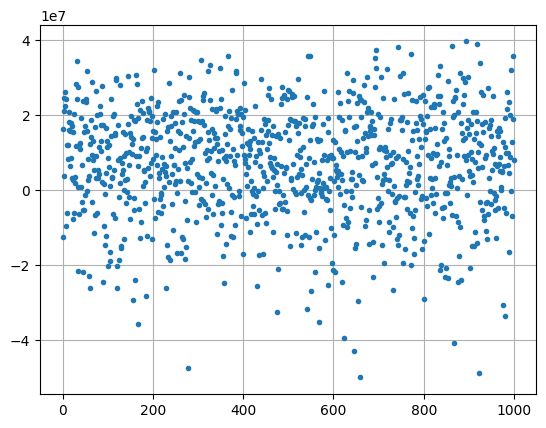

In [8]:
plt.plot(prices[:1000], ".")
plt.grid()
plt.show()

In [9]:
prices

<tf.Tensor: shape=(1000000, 1), dtype=float64, numpy=
array([[ 16209413.94166907],
       [-12699377.20344334],
       [  3565753.08963486],
       ...,
       [ -3821739.58772577],
       [  2592861.62098769],
       [  2064472.11156296]])>